<a href="https://colab.research.google.com/github/Mubashar-Bashir/Langchain_EcoSystem/blob/main/Basic_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Quick Start
In this comprehensive quick start, we will build a support chatbot in LangGraph that can:

<li>Answer common questions by searching the web
<li>Maintain conversation state across calls
<li>Route complex queries to a human for review
<li>Use custom state to control its behavior
Rewind and explore alternative conversation paths

We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way.

<b>Setup

First, install the required packages:

In [7]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai

In [8]:
LANGCHAIN_TRACING_V2="true"
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_API_KEY="<your-api-key>"
LANGCHAIN_PROJECT="Basic_chatbot"

In [9]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] ="Basic_chatbot"

gemini_api_key = userdata.get('Gemini-key')
os.environ["Gemini-key"] = gemini_api_key

In [10]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

llm.invoke("greet me")

AIMessage(content='Hello there! How can I help you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-78d45511-120e-4ba4-bb08-f5b8e8ee69fd-0', usage_metadata={'input_tokens': 3, 'output_tokens': 10, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

**Part 1: Build a Basic Chatbot**
We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

Start by creating a StateGraph. A StateGraph object defines the structure of our chatbot as a "state machine". We'll add nodes to represent the llm and functions our chatbot can call and edges to specify how the bot should transition between these functions.**bold text**

In [11]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


In [12]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


In [13]:
# print(chatbot(State(messages=["Hi"])))

{'messages': [AIMessage(content='Hi! What can I do for you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-8db91b6b-5b9e-4fa8-b1d1-659b13ebe312-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})]}


In [15]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()


ValueError: Node `chatbot` already present.

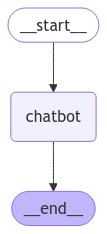

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [30]:
response = graph.invoke({"messages": ["Hi"]})


In [20]:
response = graph.stream({"messages": ["Hi"]})
for event in response:
    print("EVENT:", list(event.values())[0]["messages"][-1].content)

EVENT: Hi! How can I help you today? 



In [21]:
for event in graph.stream({"messages": [("user", "I am Mubashar")]}):
    print("EVENT:", list(event.values())[0]["messages"][-1].content)

EVENT: Hello Mubashar! It's nice to meet you. What can I do for you today? 



In [22]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: what is my name
Assistant: As an AI, I do not have access to personal information like your name.  If you want to tell me your name, I'd be happy to learn it! 

User: My name is Mubashar
Assistant: Hello Mubashar, it's nice to meet you! What can I do for you today? 

User: what is my previous Question
Assistant: Please provide me with some context! I have no memory of past conversations. To help me understand what your previous question was, please tell me:

* **What were we talking about before?** 
* **What was the topic of our last conversation?**
* **Can you give me any keywords or phrases from your previous question?**

Once you give me some information, I can try to help you remember what your previous question was. 😊 

User: what is my name
Assistant: As an AI, I do not have access to personal information about you, including your name.  

To tell me your name, you can simply type it out! 

User: q
Goodbye!


**Congratulations!** You've built your first chatbot using LangGraph. This bot can engage in basic conversation by taking user input and generating responses using an LLM. You can inspect a LangSmith Trace for the call above at the provided link.

However, you may have noticed that the bot's knowledge is limited to what's in its training data. In the next part, we'll add a web search tool to expand the bot's knowledge and make it more capable.

**Part 2: Enhancing the Chatbot with Tools**
To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

**Requirements**

Before we start, make sure you have the necessary packages installed and API keys set up:

First, install the requirements to use the Tavily Search Engine, and set your TAVILY_API_KEY.

In [31]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [32]:
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

Next, define the tool:

In [33]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"}]

The results are page summaries our chat bot can use to answer questions.

Next, we'll start defining our graph. The following is all the same as in Part 1, except we have added bind_tools on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [34]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


In [35]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, we implement a BasicToolNode that checks the most recent message in the state and calls tools if the message contains tool_calls. It relies on the LLM's tool_calling support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt ToolNode to speed things up, but building it ourselves first is instructive.

In [36]:
tools_by_name = {tool.name: tool for tool in tools}
print(type(tools_by_name))
print(tools_by_name)

tools_by_name["tavily_search_results_json"]

llm_with_tools.invoke("search using tool and what polls say about winner 2024 presidential elections")

<class 'dict'>
{'tavily_search_results_json': TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}


AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "what polls say about winner 2024 presidential elections"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-5e8637d2-888d-4305-a12f-737e1bbc725a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'what polls say about winner 2024 presidential elections'}, 'id': '95c381b8-e27a-49cd-99b8-f4d583644ccb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 90, 'output_tokens': 31, 'total_tokens'

In [37]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [38]:
from langchain_core.messages import HumanMessage, AIMessage

messages = [
AIMessage(content='',
          additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "2024 presidential elections polls"}'}},
          response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []},
          id='run-621e608b-24ae-4d50-8605-33415037f7df-0',
          tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '2024 presidential elections polls'}, 'id': '826c7148-a96a-4f79-9c64-325c97489d5e', 'type': 'tool_call'}],
          usage_metadata={'input_tokens': 90, 'output_tokens': 16, 'total_tokens': 106, 'input_token_details': {'cache_read': 0}})
]

tool_node(inputs={"messages": messages})

{'messages': [ToolMessage(content='[{"url": "https://projects.fivethirtyeight.com/2024-election-forecast/", "content": "With the 2024 presidential election a week away, 538\'s Galen Druke and G. Elliott Morris discuss the relevancy of early voting data. October 29, 2024. The 2024 election could hinge on Pennsylvania. ... What the polls say about the 2024 election."}, {"url": "https://www.cnn.com/election/2024", "content": "2024 election guide: Presidential candidates, polls, primaries and caucuses, voter information and results for November 5, 2024"}]', name='tavily_search_results_json', tool_call_id='826c7148-a96a-4f79-9c64-325c97489d5e')]}

With the tool node added, we can define the conditional_edges.

Recall that edges route the control flow from one node to the next. Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called route_tools, that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling add_conditional_edges, which tells the graph that whenever the chatbot node completes to check this function to see where to go next.

The condition will route to tools if tool calls are present and END if not.

Later, we will replace this with the prebuilt tools_condition to be more concise, but implementing it ourselves first makes things more clear.

In [39]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

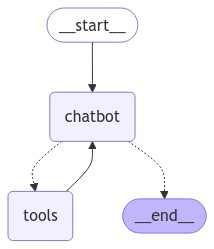

In [40]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [41]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: who is currently president in 2024
Assistant: 
Assistant: [{"url": "https://projects.fivethirtyeight.com/2024-election-forecast/", "content": "With the 2024 presidential election a week away, 538's Galen Druke and G. Elliott Morris discuss the relevancy of early voting data. ... discusses the strategic differences between the Harris campaign when addressing inflation and the economy compared to President Joe Biden. ... Currently, our forecast gives Trump a XXX out of 100 chance of"}, {"url": "https://abcnews.go.com/Politics/2024-presidential-election-historic-matter-wins/story?id=115359466", "content": "The 2024 presidential race will come to an end in a matter of days. Whatever the outcome, history will be made. Vice President Kamala Harris would be the first woman to serve as president of the"}]
Assistant: It is difficult to say for sure who will be president in 2024 as the election is still a week away.  The current president is Joe Biden.  I can't provide any predictions abou

In [42]:
from typing import Annotated

# from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm=llm
# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

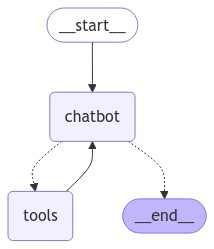

In [43]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [44]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: who is pm pak 2026
Assistant: 
Assistant: [{"url": "https://apnews.com/article/pakistan-new-government-cabinet-sworn-44eef2840d8636361a2a05167cd83579", "content": "In this photo released by the Pakistan's President Office, President Asif Ali Zardari, center left, administers the oath from federal ministers as Prime Minister Shehbaz Sharif, center right, watches during a ceremony at the Presidential Palace, in Islamabad, Pakistan, Monday, March 11, 2024."}, {"url": "https://www.voanews.com/a/pakistan-comes-close-to-getting-new-government-after-disputed-polls-/7486335.html", "content": "Sharif's Pakistan Muslim League-N (PML-N) made the announcement after emerging as the single largest party with 80 seats in Thursday's vote but not enough for a simple majority in the 266-seat"}]
Assistant: I am sorry, I cannot provide you with information about the Prime Minister of Pakistan in 2026. My knowledge about future events is limited. 

User: current update of gpt
Assistant: I do not have

##**Part 3: Adding Memory to the Chatbot**
Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through persistent checkpointing. If you provide a checkpointer when compiling the graph and a thread_id when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same thread_id, the graph loads its saved state, allowing the chatbot to pick up where it left off.

We will see later that checkpointing is much more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But before we get too ahead of ourselves, let's add checkpointing to enable multi-turn conversations.

To get started, create a MemorySaver checkpointer.

In [45]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Notice we're using an in-memory checkpointer. This is convenient for our tutorial (it saves it all in-memory). In a production application, you would likely change this to use SqliteSaver or PostgresSaver and connect to your own DB.

Next define the graph. Now that you've already built your own BasicToolNode, we'll replace it with LangGraph's prebuilt ToolNode and tools_condition, since these do some nice things like parallel API execution. Apart from that, the following is all copied from Part 2.

In [46]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


In [47]:


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Finally, compile the graph with the provided checkpointer.

In [48]:
graph = graph_builder.compile(checkpointer=memory)


Notice the connectivity of the graph hasn't changed since Part 2. All we are doing is checkpointing the State as the graph works through each node.

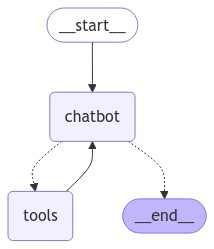

In [49]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now you can interact with your bot! First, pick a thread to use as the key for this conversation.

In [50]:
config = {"configurable": {"thread_id": "1"}}


Next, call your chat bot.

In [51]:
user_input = "Hi there! My name is Mubashar."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Mubashar.
================================== Ai Message ==================================

Nice to meet you, Mubashar! How can I help you today?


**Note:** The config was provided as the second positional argument when calling our graph. It importantly is not nested within the graph inputs ({'messages': []}).

Let's ask a followup: see if it remembers your name.

In [52]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I will try my best to remember your name, Mubashar!  😊  Is there anything else I can help you with?


**Notice** that we aren't using an external list for memory: it's all handled by the checkpointer! You can inspect the full execution in this LangSmith trace to see what's going on.

Don't believe me? Try this using a different config.

In [53]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I am sorry, I do not have memory of past conversations. I am a language model and do not have the ability to store personal information.


**Notice** that the only change we've made is to modify the thread_id in the config. See this call's LangSmith trace for comparison.

By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's state for a given config at any time, call get_state(config).

In [54]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Mubashar.', additional_kwargs={}, response_metadata={}, id='bbd2d377-333b-4175-8953-e84dc4197f59'), AIMessage(content='Nice to meet you, Mubashar! How can I help you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-3c2a5c91-bc19-4a3a-8273-9566eb83a844-0', usage_metadata={'input_tokens': 85, 'output_tokens': 17, 'total_tokens': 102, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Remember my name?', additional_

In [55]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)


()

The snapshot above contains the current state values, corresponding config, and the next node to process. In our case, the graph has reached an END state, so next is empty.

Congratulations! Your chatbot can now maintain conversation state across sessions thanks to LangGraph's checkpointing system. This opens up exciting possibilities for more natural, contextual interactions. LangGraph's checkpointing even handles arbitrarily complex graph states, which is much more expressive and powerful than simple chat memory.

In the next part, we'll introduce human oversight to our bot to handle situations where it may need guidance or verification before proceeding.